---
> # **BACKTEST** - Estratégia _Volatility_
---

A estratégia é assim:

* Timeframe de 10min;
* Indicadores:
  * Bandas de Volatilidade sobre os retornos
* Sinal de entrada de compra:
  * Quando o retorno fechar abaixo da banda inferior
  * Comprar abertura do próximo candle
* Sinal de entrada de venda:
  * Quando o retorno fechar acima da banda superior
  * Venda na abertura no próximo candle
* Stop de 0.5% com alvo 3x o risco;


# 1. Bibliotecas

In [1]:
# Análise e manipulação de dados gerais
import numpy as np
import pandas as pd

import pandas_ta as ta

# Dados séries temporais
from datetime import datetime, timedelta
import pytz

# Dados OHLCV
from mt5linux import MetaTrader5

# connecto to the server
mt5 = MetaTrader5()
mt5.execute('import datetime')

# Bibliotecas gráficas
import mplfinance as mpf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
mt5.initialize()

True

In [3]:
def get_data(ticker, timeframe, data_inicio, data_fim, media, desv):
    dados_ohlcv = mt5.copy_rates_range(ticker, timeframe, data_inicio, data_fim)
    dados_ohlcv = pd.DataFrame(dados_ohlcv)
    dados_ohlcv['ticker'] = str(ticker)
    dados_ohlcv.index = pd.to_datetime(dados_ohlcv['time'], unit='s')
    dados_ohlcv = dados_ohlcv.drop('time', axis=1)
    
    dados_ohlcv['retorno'] = dados_ohlcv['close']/dados_ohlcv['close'].shift(1) - 1
    dados_ohlcv['media'] = dados_ohlcv['retorno'].rolling(media).mean()
    dados_ohlcv['desvio'] = dados_ohlcv['retorno'].rolling(media).std()
    
    dados_ohlcv['bandupper']  = dados_ohlcv['media'] + (desv*dados_ohlcv['desvio'])
    dados_ohlcv['bandlow'] =  dados_ohlcv['media'] - (desv*dados_ohlcv['desvio'])
    return dados_ohlcv

In [4]:
def sinal_compra(retorno, bandlow):
    regra1 = retorno <= bandlow
    regra2 = retorno != 0
    return regra1 & regra2

def sinal_venda(retorno, bandhigh):
    regra = retorno >= bandhigh
    regra2 = retorno != 0
    return regra & regra2

In [5]:
timezone = pytz.timezone("America/Sao_Paulo")
data_inicio = datetime.now() - timedelta(days=250)
data_fim = datetime.now()

# 2. Obtenção dos dados

In [6]:
ticker = 'AZUL4'

df = get_data(ticker, mt5.TIMEFRAME_M10, data_inicio, data_fim, 21, 2)
df['compra'] = sinal_compra(df.retorno, df.bandlow)
df['venda'] = sinal_venda(df.retorno, df.bandupper)
df.head()

,open,high,low,close,tick_volume,spread,real_volume,ticker,retorno,media,desvio,bandupper,bandlow,compra,venda
time,,,,,,,,,,,,,,,
2022-07-29 12:40:00,11.78,11.81,11.77,11.77,115,1,56300,AZUL4,NaN,NaN,NaN,NaN,NaN,False,False
2022-07-29 12:50:00,11.77,11.78,11.70,11.70,168,1,118200,AZUL4,-0.005947,NaN,NaN,NaN,NaN,False,False
2022-07-29 13:00:00,11.70,11.71,11.65,11.66,199,1,88400,AZUL4,-0.003419,NaN,NaN,NaN,NaN,False,False
2022-07-29 13:10:00,11.67,11.72,11.66,11.71,150,1,134700,AZUL4,0.004288,NaN,NaN,NaN,NaN,False,False
2022-07-29 13:20:00,11.71,11.71,11.69,11.70,53,1,16100,AZUL4,-0.000854,NaN,NaN,NaN,NaN,False,False


## 2.1 Filtro de compra

In [7]:
df_compra = df[df.compra == True]
df_compra.tail()

,open,high,low,close,tick_volume,spread,real_volume,ticker,retorno,media,desvio,bandupper,bandlow,compra,venda
time,,,,,,,,,,,,,,,
2023-03-31 14:40:00,11.89,11.89,11.72,11.72,398,1,337400,AZUL4,-0.013468,-0.002286,0.004907,0.007527,-0.012099,True,False
2023-04-03 10:00:00,11.60,11.68,11.52,11.64,216,1,250900,AZUL4,-0.032419,-0.001491,0.008836,0.016182,-0.019164,True,False
2023-04-04 10:40:00,11.72,11.72,11.59,11.62,354,1,353100,AZUL4,-0.008532,0.000499,0.003240,0.006980,-0.005981,True,False
2023-04-04 11:20:00,11.74,11.74,11.61,11.65,299,1,159000,AZUL4,-0.007666,0.000874,0.003950,0.008773,-0.007025,True,False
2023-04-04 11:30:00,11.65,11.67,11.53,11.54,310,1,198700,AZUL4,-0.009442,0.000383,0.004546,0.009475,-0.008710,True,False


## 2.2 Filtro de Venda

In [8]:
df_venda = df[df.venda == True]
df_venda.tail()

,open,high,low,close,tick_volume,spread,real_volume,ticker,retorno,media,desvio,bandupper,bandlow,compra,venda
time,,,,,,,,,,,,,,,
2023-03-30 10:10:00,11.91,12.38,11.84,12.30,942,1,883300,AZUL4,0.031879,0.002597,0.010249,0.023095,-0.017900,False,True
2023-03-31 10:30:00,12.15,12.40,12.13,12.38,831,1,879100,AZUL4,0.018930,0.000559,0.006046,0.012651,-0.011532,False,True
2023-04-04 10:00:00,11.66,11.72,11.53,11.60,296,1,314000,AZUL4,0.006071,0.000539,0.002308,0.005155,-0.004076,False,True
2023-04-04 10:10:00,11.58,11.67,11.57,11.67,198,1,200600,AZUL4,0.006034,0.000744,0.002592,0.005928,-0.004441,False,True
2023-04-04 11:00:00,11.65,11.76,11.63,11.74,296,1,273100,AZUL4,0.008591,0.001198,0.003485,0.008168,-0.005773,False,True


## 2.3 Visualizando as entradas de compra

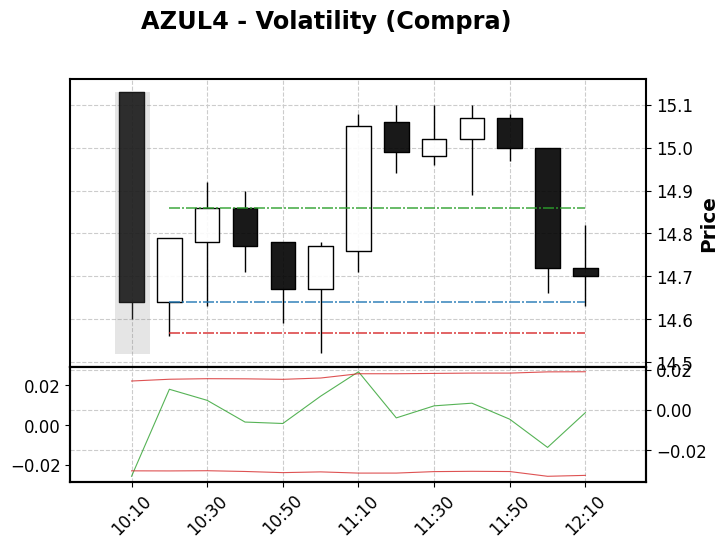

In [9]:
n_index = 9
inicio = df_compra.iloc[n_index].name
fim = df_compra.iloc[n_index].name + timedelta(minutes=120)

sl = 0.5
tp = 1.5

stop = 1-(sl/100)
take = 1+(tp/100)

candle_index_signal = 0
candle_index = 1

dfpl = df.loc[inicio:fim]

candle_signal = dfpl.index[candle_index_signal].strftime('%Y-%m-%d %H:%M:%S')

candle_start_op = dfpl.index[candle_index].strftime('%Y-%m-%d %H:%M:%S')
candle_end_op = dfpl.index[-1].strftime('%Y-%m-%d %H:%M:%S')

ponto_entrada = dfpl['open'].loc[candle_start_op]
ponto_stop = dfpl['open'].loc[candle_start_op] * stop
ponto_take = dfpl['open'].loc[candle_start_op] * take

lines = [[(candle_start_op,ponto_stop),(candle_end_op, ponto_stop)],
         [(candle_start_op,ponto_entrada),(candle_end_op, ponto_entrada)],
         [(candle_start_op,ponto_take),(candle_end_op, ponto_take)]]

adp = [mpf.make_addplot(dfpl.retorno, color='tab:green', width=0.8, alpha=0.8, panel=1),
      mpf.make_addplot(dfpl.bandlow, color='tab:red', width=0.8, alpha=0.8, panel=1),
      mpf.make_addplot(dfpl.bandupper, color='tab:red', width=0.8, alpha=0.8, panel=1)]

alines = dict(alines=lines, linestyle='-.', colors=['tab:red', 'tab:blue', 'tab:green'], alpha=0.7, linewidths=1.2)
vlines=dict(vlines=candle_signal,linewidths=25, alpha=0.2, colors='tab:gray')
mpf.plot(dfpl, title=f'{ticker} - Volatility (Compra)', type='candle', style='classic', vlines=vlines, alines=alines, addplot=adp)

## 2.4 Visualizando as entradas de venda

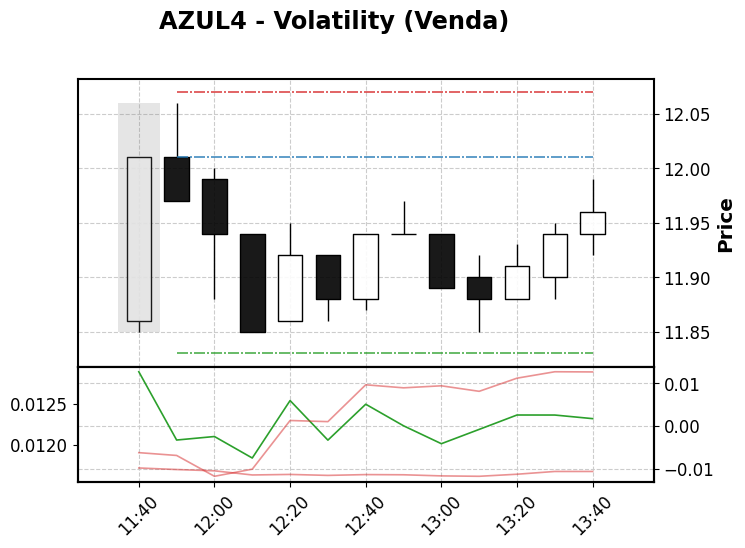

In [10]:
n_index = 1
inicio = df_venda.iloc[n_index].name
fim = df_venda.iloc[n_index].name + timedelta(minutes=120)

sl = 0.5
tp = 1.5

stop = 1+(sl/100)
take = 1-(tp/100)

candle_index_signal = 0
candle_index = 1

dfpl = df.loc[inicio:fim]

candle_signal = dfpl.index[candle_index_signal].strftime('%Y-%m-%d %H:%M:%S')

candle_start_op = dfpl.index[candle_index].strftime('%Y-%m-%d %H:%M:%S')
candle_end_op = dfpl.index[-1].strftime('%Y-%m-%d %H:%M:%S')

ponto_entrada = dfpl['open'].loc[candle_start_op]
ponto_stop = dfpl['open'].loc[candle_start_op] * stop
ponto_take = dfpl['open'].loc[candle_start_op] * take

lines = [[(candle_start_op,ponto_stop),(candle_end_op, ponto_stop)],
         [(candle_start_op,ponto_entrada),(candle_end_op, ponto_entrada)],
         [(candle_start_op,ponto_take),(candle_end_op, ponto_take)]]

adp = [mpf.make_addplot(dfpl.retorno, color='tab:green', width=1.2, panel=1),
      mpf.make_addplot(dfpl.bandlow, color='tab:red', width=1.2, alpha=0.5, panel=1),
      mpf.make_addplot(dfpl.bandupper, color='tab:red', width=1.2, alpha=0.5, panel=1)]

alines = dict(alines=lines, linestyle='-.', colors=['tab:red', 'tab:blue', 'tab:green'], alpha=0.7, linewidths=1.2)
vlines=dict(vlines=candle_signal,linewidths=30, alpha=0.2, colors='tab:gray')
mpf.plot(dfpl, title=f'{ticker} - Volatility (Venda)', type='candle', style='classic', vlines=vlines, alines=alines, addplot=adp)

# 3. Backtest

In [11]:
position = 0

risco_retorno = 3
valor_inicial = 0.5

stop_compra = 1 - (valor_inicial/100)
take_compra = 1 + ((valor_inicial*risco_retorno)/100)

stop_venda = 1 + (valor_inicial/100)
take_venda = 1 - ((valor_inicial*risco_retorno)/100)

ls_data_compra_entrada = []
ls_preco_compra_entrada = []

ls_data_compra_saida = []
ls_preco_compra_saida = []

ls_data_venda_entrada = []
ls_preco_venda_entrada = []

ls_data_venda_saida = []
ls_preco_venda_saida = []

for i in range(len(df)):
    # Procurando por compras
    if (position == 0) and (df['compra'].iloc[i-1] == True) and (df.index[i].hour <= 15):
        ponto_entrada = df['open'].iloc[i]
        stop_loss = round(ponto_entrada * stop_compra, 2)
        take_profit = round(ponto_entrada * take_compra, 2)
        
        ls_data_compra_entrada.append(df.index[i])
        ls_preco_compra_entrada.append(ponto_entrada)
        position = 1
        
    # Stop loss de compra
    elif (position == 1) and (df['low'].iloc[i] <= stop_loss):
        ls_data_compra_saida.append(df.index[i])
        ls_preco_compra_saida.append(stop_loss)
        position = 0
    # Take profit de compra
    elif (position == 1) and (df['high'].iloc[i] >= take_profit):
        ls_data_compra_saida.append(df.index[i])
        ls_preco_compra_saida.append(take_profit)
        position = 0
    # Saída de compra pelo final do pregão
    elif (position == 1) and (df.index[i].hour >= 16):
        ls_data_compra_saida.append(df.index[i])
        ls_preco_compra_saida.append(df['close'].iloc[i])
        position = 0
    
    # Procurando por vendas
    if (position == 0) and (df['venda'].iloc[i-1] == True) and (df.index[i].hour <= 15):
        ponto_entrada = df['open'].iloc[i]
        stop_loss = round(ponto_entrada * stop_venda, 2)
        take_profit = round(ponto_entrada * take_venda, 2)
        
        ls_data_venda_entrada.append(df.index[i])
        ls_preco_venda_entrada.append(ponto_entrada)
        position = -1
    
    # Stop loss de venda
    elif (position == -1) and (df['high'].iloc[i] >= stop_loss):
        ls_data_venda_saida.append(df.index[i])
        ls_preco_venda_saida.append(stop_loss)
        position = 0
    # Take Profit de venda
    elif (position == -1) and (df['low'].iloc[i] <= take_profit):
        ls_data_venda_saida.append(df.index[i])
        ls_preco_venda_saida.append(take_profit)
        position = 0
    # Saída da venda pelo final do pregão
    elif (position == -1) and (df.index[i].hour >= 16):
        ls_data_venda_saida.append(df.index[i])
        ls_preco_venda_saida.append(df['close'].iloc[i])
        position = 0

## 3.1 - Computando os resultados das COMPRAS

In [12]:
tabela_result_compras = pd.DataFrame(zip(ls_data_compra_entrada, ls_preco_compra_entrada, ls_data_compra_saida, ls_preco_compra_saida),
                                    columns=['data_entrada', 'preco_entrada', 'data_saida', 'preco_saida'])
tabela_result_compras['data_entrada'] = pd.to_datetime(tabela_result_compras['data_entrada'], errors='ignore')
tabela_result_compras['data_saida'] = pd.to_datetime(tabela_result_compras['data_saida'], errors='ignore')
tabela_result_compras['resultado'] = (tabela_result_compras['preco_saida']/tabela_result_compras['preco_entrada'] - 1)*100
tabela_result_compras['resultado_pontos'] = tabela_result_compras['preco_saida'] - tabela_result_compras['preco_entrada']
tabela_result_compras['tipo'] = 'COMPRA'
tabela_result_compras.tail()

,data_entrada,preco_entrada,data_saida,preco_saida,resultado,resultado_pontos,tipo
159,2023-03-30 10:50:00,12.35,2023-03-30 11:00:00,12.29,-0.485830,-0.06,COMPRA
160,2023-03-31 14:50:00,11.73,2023-03-31 15:30:00,11.91,1.534527,0.18,COMPRA
161,2023-04-03 10:10:00,11.66,2023-04-03 10:20:00,11.60,-0.514580,-0.06,COMPRA
162,2023-04-04 10:50:00,11.63,2023-04-04 11:10:00,11.80,1.461737,0.17,COMPRA
163,2023-04-04 11:40:00,11.54,2023-04-04 11:50:00,11.48,-0.519931,-0.06,COMPRA


## 3.2 - Computando os resultados das VENDAS

In [13]:
tabela_result_vendas = pd.DataFrame(zip(ls_data_venda_entrada, ls_preco_venda_entrada, ls_data_venda_saida, ls_preco_venda_saida),
                                    columns=['data_entrada', 'preco_entrada', 'data_saida', 'preco_saida'])
tabela_result_vendas['data_entrada'] = pd.to_datetime(tabela_result_vendas['data_entrada'], errors='ignore')
tabela_result_vendas['data_saida'] = pd.to_datetime(tabela_result_vendas['data_saida'], errors='ignore')
tabela_result_vendas['resultado'] = (tabela_result_vendas['preco_entrada']/tabela_result_vendas['preco_saida'] - 1)*100
tabela_result_vendas['resultado_pontos'] = tabela_result_vendas['preco_entrada'] - tabela_result_vendas['preco_saida']
tabela_result_vendas['tipo'] = 'VENDA'
tabela_result_vendas.tail()

,data_entrada,preco_entrada,data_saida,preco_saida,resultado,resultado_pontos,tipo
163,2023-03-29 10:40:00,11.77,2023-03-29 10:50:00,11.83,-0.507185,-0.06,VENDA
164,2023-03-30 10:10:00,11.91,2023-03-30 10:20:00,11.97,-0.501253,-0.06,VENDA
165,2023-03-31 10:40:00,12.38,2023-03-31 10:50:00,12.19,1.558655,0.19,VENDA
166,2023-04-04 10:10:00,11.58,2023-04-04 10:20:00,11.64,-0.515464,-0.06,VENDA
167,2023-04-04 11:10:00,11.73,2023-04-04 11:30:00,11.55,1.558442,0.18,VENDA


## 3.3 - Computando o resultado final

In [14]:
df_final = pd.concat([tabela_result_compras, tabela_result_vendas])
df_final = df_final.sort_values(by='data_entrada').reset_index(drop=True)
df_final

,data_entrada,preco_entrada,data_saida,preco_saida,resultado,resultado_pontos,tipo
0,2022-08-01 10:00:00,11.61,2022-08-01 10:30:00,11.55,-0.516796,-0.06,COMPRA
1,2022-08-01 10:40:00,11.50,2022-08-01 10:50:00,11.67,1.478261,0.17,COMPRA
2,2022-08-01 10:50:00,11.63,2022-08-01 11:00:00,11.69,-0.513259,-0.06,VENDA
3,2022-08-01 11:50:00,12.01,2022-08-01 14:20:00,11.83,1.521555,0.18,VENDA
4,2022-08-02 10:10:00,11.70,2022-08-02 10:30:00,11.64,-0.512821,-0.06,COMPRA
...,...,...,...,...,...,...,...
327,2023-04-03 10:10:00,11.66,2023-04-03 10:20:00,11.60,-0.514580,-0.06,COMPRA
328,2023-04-04 10:10:00,11.58,2023-04-04 10:20:00,11.64,-0.515464,-0.06,VENDA
329,2023-04-04 10:50:00,11.63,2023-04-04 11:10:00,11.80,1.461737,0.17,COMPRA
330,2023-04-04 11:10:00,11.73,2023-04-04 11:30:00,11.55,1.558442,0.18,VENDA


# 4. Visualizando o resultado final

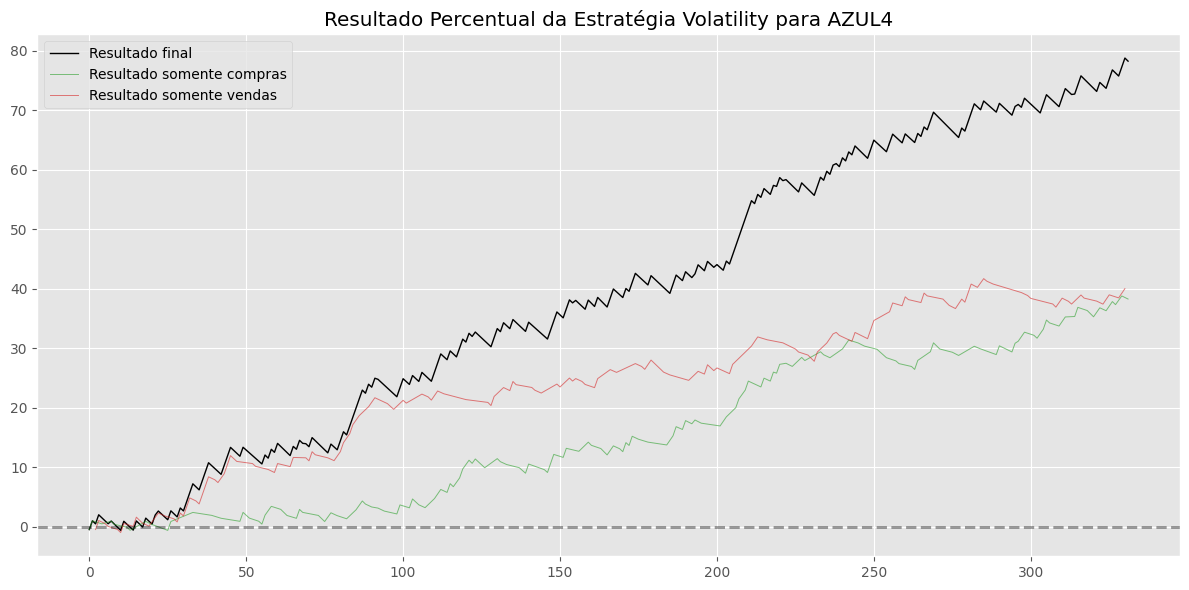

In [15]:
plt.style.use('ggplot')

plt.figure(figsize=(12,6))
plt.title(f'Resultado Percentual da Estratégia Volatility para {ticker}')
plt.plot(df_final['resultado'].cumsum(), label='Resultado final', lw=1, color='black')
plt.plot(df_final[df_final['tipo'] == 'COMPRA']['resultado'].cumsum(), color='tab:green', label='Resultado somente compras', alpha=0.6, lw=0.7)
plt.plot(df_final[df_final['tipo'] == 'VENDA']['resultado'].cumsum(), color='tab:red', label='Resultado somente vendas', alpha=0.6, lw=0.7)

plt.axhline(0, color='black', ls='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show();

In [16]:
soma_compra = df_final[df_final['tipo'] == 'COMPRA']['resultado'].sum()
soma_venda = df_final[df_final['tipo'] == 'VENDA']['resultado'].sum()

qtd_compra = df_final[df_final['tipo'] == 'COMPRA']['resultado'].count()
qtd_venda = df_final[df_final['tipo'] == 'VENDA']['resultado'].count()

acertos = len(df_final[df_final['resultado'] > 0])
perdas = len(df_final[df_final['resultado'] <= 0])

print(f'\n\nBacktest do Volatility {ticker}')

print(f'\nInício do backtest: {df.index[0]}')
print(f'Fim do backtest: {df.index[-1]}')
print(f'Quantidade de dias: {df.index[-1] - df.index[0]}')

print(f'\nQuantidade total de operações: {len(df_final)}')
print(f'Quantidade de operações de compra: {qtd_compra}')
print(f'Quantidade de operações de venda: {qtd_venda}')

print(f'\nSoma percentual de operações de compra: {round(soma_compra, 2)}')
print(f'Soma percentual de operações de venda: {round(soma_venda, 2)}')

print(f'\nTaxa de acerto: {round((acertos/(acertos+perdas))*100, 2)}%')

print(f'\nResultado final: {round(soma_compra + soma_venda, 2)}%')
print(f'Média percentual de lucro por trade: {round((df_final["resultado"].mean()), 2)}%')
print(f'Média de centavos de lucro por trade: {round(df_final["resultado_pontos"].mean(), 2)} centavos')



Backtest do Volatility AZUL4

Início do backtest: 2022-07-29 12:40:00
Fim do backtest: 2023-04-04 16:50:00
Quantidade de dias: 249 days 04:10:00

Quantidade total de operações: 332
Quantidade de operações de compra: 164
Quantidade de operações de venda: 168

Soma percentual de operações de compra: 38.23
Soma percentual de operações de venda: 39.98

Taxa de acerto: 37.95%

Resultado final: 78.21%
Média percentual de lucro por trade: 0.24%
Média de centavos de lucro por trade: 0.03 centavos
